In [1]:
import numpy as np
import casadi as ca
import matplotlib.pyplot as plt

In [2]:
def integrator_rk4(f, x, u, p, delta_t):
        '''
        This function calculates the integration of stage cost with RK4.
        '''

        k1 = f(x, u, p)
        k2 = f(x + delta_t / 2 * k1, u, p)
        k3 = f(x + delta_t / 2 * k2, u, p)
        k4 = f(x + delta_t * k3, u, p)

        x_next = x + delta_t / 6 * (k1 + 2 * k2 + 2 * k3 + k4)
        return x_next

### Test1

$\dot{x}_{1}=x_{2}, \quad \dot{x}_{2}=-\frac{k_{2}}{m} x_{1}^{3}-\frac{k_{1}}{m} x_{2}+\frac{1}{m} u+\theta_{1}$

In [16]:
def academic_model(x, u, p):
    m = 2  # [kg]
    k1 = 3  # [N/m]
    k2 = 2  # [N/m]

    #     A = ca.DM([[0, 1], [-k2 / m, -k1 / m]])
    #     B = ca.DM([[0], [1 / m]])

    x1p = x[1]
    x2p = -k2 / m * x[0] ** 3 - k1 / m * x[1] + 1 / m * u[0] + p

    rhs = [x1p,
           x2p
           ]

    return ca.vertcat(*rhs)

In [17]:
Nx = 2
Nu = 1
N_theta = 1 

x_SX = ca.SX.sym("x_SX", Nx)
u_SX = ca.SX.sym("u_SX", Nu)
theta_SX = ca.SX.sym("theta_SX", N_theta)
t_SX = ca.SX.sym("t", 1)

delta_t = 0.1

ode = ca.Function("ode_func", [x_SX, u_SX, theta_SX], [academic_model(x_SX, u_SX, theta_SX)])
ode_dis_SX = integrator_rk4(ode, x_SX, u_SX, theta_SX, delta_t)

ode_dis_func = ca.Function("ode_dis", [x_SX, u_SX, theta_SX], [ode_dis_SX])

In [18]:
N_sim = 30
N_traj = 500
x_init = [0,0]

theta_dist = 1

uk = 0

traj_list = []
for i in range(N_traj):
    xk = x_init
    traj_temp_list = []
    traj_temp_list += xk
    for j in range(N_sim):
        theta_k = np.random.uniform(-theta_dist,theta_dist,1)
        xk_p1 = ode_dis_func(xk,uk,theta_k)
        traj_temp_list += xk_p1.full().flatten().tolist()
        xk = xk_p1
    traj_list += [traj_temp_list]

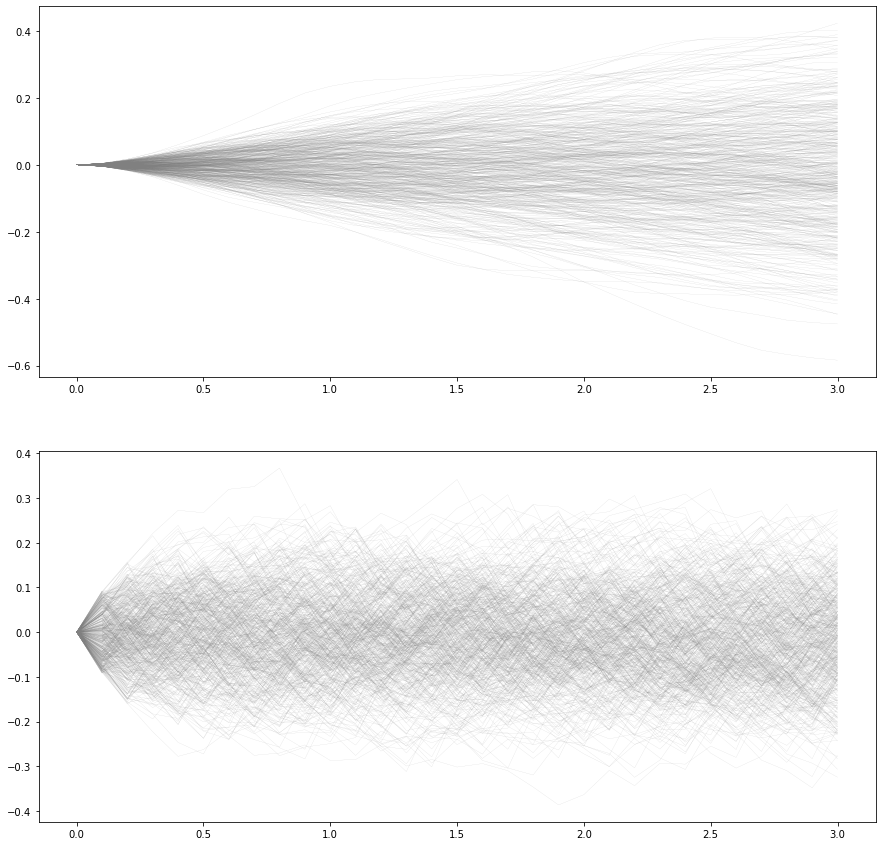

In [19]:
tgrid = [delta_t * k for k in range(N_sim + 1)]

# plt.figure(1, figsize=(10, 20))
# plt.clf()
f, [ax1,ax2] = plt.subplots(2,1,figsize=(15,15))



for i in range(len(traj_list)):
    x_trajectory_temp = traj_list[i]
    for j in range (Nx):
        x_opt = x_trajectory_temp[j::Nx]
        if j == 0:
            ax1.plot(tgrid, x_opt, 'grey',alpha=0.7,lw=0.1)
        else:
            ax2.plot(tgrid, x_opt, 'grey',alpha=0.7,lw=0.1)

# ax2.plot(tgrid, x2_mean, 'r', lw=3)
plt.show()

### test2 CSTR model

System comes from: Nonlinear CSTR control system design using an artificial bee
colony algorithm

$\dot{x}_{1}=-x_{1}+D_{a}\left(1-x_{1}\right) \exp \left(\frac{x_{2}}{1+x_{2} / \varphi}\right)$

$\dot{x}_{2}=-(1+\delta) x_{2}+B \cdot D_{a}\left(1-x_{2}\right) \exp \left(\frac{x_{2}}{1+x_{2} / \varphi}\right)+\delta \cdot u$

with $D_{a}=0.072, \varphi=20, B=8$ and $\delta=0.3$

and for $u=0$, equilibrium points, $\left(x_{1}, x_{2}\right)=(0.144,0.886)_{s \cdot}\left(x_{1}, x_{2}\right)=(0.445,2.74)_{u}$, and $\left(x_{1}, x_{2}\right)=(0.765,4.705)_{s}$,

In [102]:
def CSTR(x, u, p):
    Da = 0.072
    phi = 20
    B = 8
    delta = 0.3
    
    
    x1p = -x[0] + Da * (1 - x[0]) * ca.exp(x[1] / (1 + x[1]/phi))
    x2p = -(1 + delta) * x[1] + B* Da * (1 - x[0]) * ca.exp(x[1] / (1 + x[1]/phi)) + delta * u + p
    
    rhs = [x1p,
           x2p
           ]

    return ca.vertcat(*rhs)

In [103]:
Nx = 2
Nu = 1
N_theta = 1 

x_SX = ca.SX.sym("x_SX", Nx)
u_SX = ca.SX.sym("u_SX", Nu)
theta_SX = ca.SX.sym("theta_SX", N_theta)
t_SX = ca.SX.sym("t", 1)

delta_t = 0.1

ode = ca.Function("ode_func", [x_SX, u_SX, theta_SX], [CSTR(x_SX, u_SX, theta_SX)])
ode_dis_SX = integrator_rk4(ode, x_SX, u_SX, theta_SX, delta_t)

ode_dis_func = ca.Function("ode_dis", [x_SX, u_SX, theta_SX], [ode_dis_SX])

In [104]:
ode([0.144,0.886],0,0)

DM([-3.12269e-05, -4.98153e-05])

#### init = [0,0]

In [111]:
N_sim = 1000
N_traj = 500
x_init = [0.3,0.5]
theta_dist = 1
uk = 0

traj_list = []
for i in range(N_traj):
    xk = x_init
    traj_temp_list = []
    traj_temp_list += xk
    for j in range(N_sim):
        theta_k = np.random.uniform(-theta_dist,theta_dist,1)
        xk_p1 = ode_dis_func(xk,uk,theta_k)
        traj_temp_list += xk_p1.full().flatten().tolist()
        xk = xk_p1
    traj_list += [traj_temp_list]

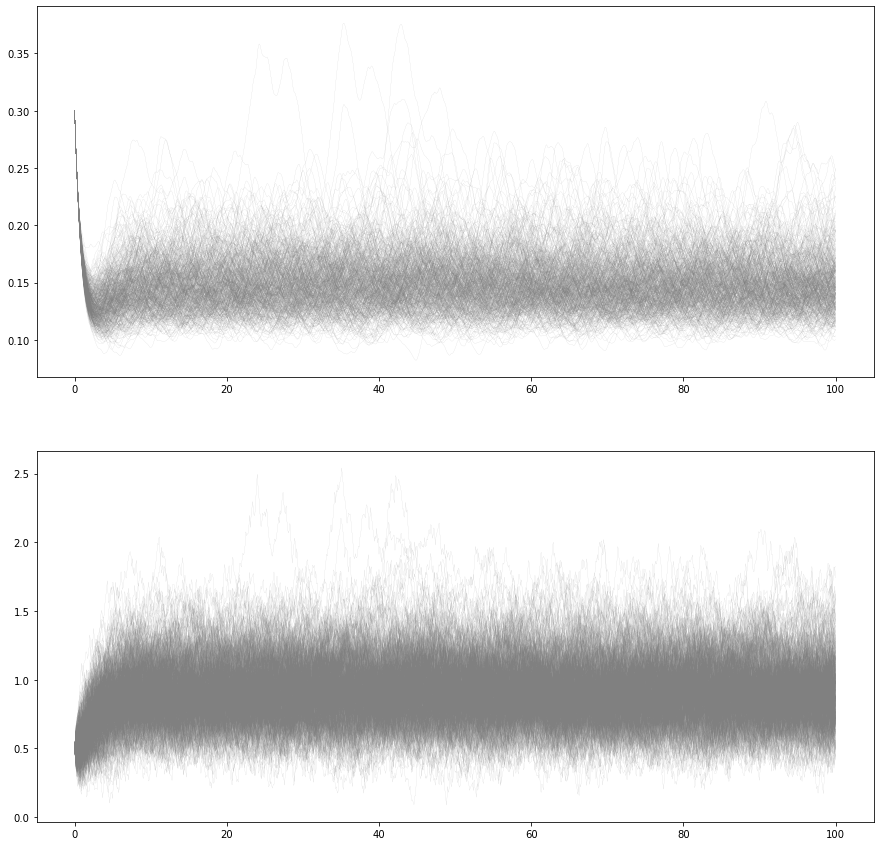

In [112]:
tgrid = [delta_t * k for k in range(N_sim + 1)]

# plt.figure(1, figsize=(10, 20))
# plt.clf()
f, [ax1,ax2] = plt.subplots(2,1,figsize=(15,15))



for i in range(len(traj_list)):
    x_trajectory_temp = traj_list[i]
    for j in range (Nx):
        x_opt = x_trajectory_temp[j::Nx]
        if j == 0:
            ax1.plot(tgrid, x_opt, 'grey',alpha=0.7,lw=0.1)
        else:
            ax2.plot(tgrid, x_opt, 'grey',alpha=0.7,lw=0.1)

# ax2.plot(tgrid, x2_mean, 'r', lw=3)
plt.show()

#### init = [0.5,3]

In [115]:
N_sim = 1000
N_traj = 500
x_init = [0.5,3.]
theta_dist = 1
uk = 0

traj_list = []
for i in range(N_traj):
    xk = x_init
    traj_temp_list = []
    traj_temp_list += xk
    for j in range(N_sim):
        theta_k = np.random.uniform(-theta_dist,theta_dist,1)
        xk_p1 = ode_dis_func(xk,uk,theta_k)
        traj_temp_list += xk_p1.full().flatten().tolist()
        xk = xk_p1
    traj_list += [traj_temp_list]

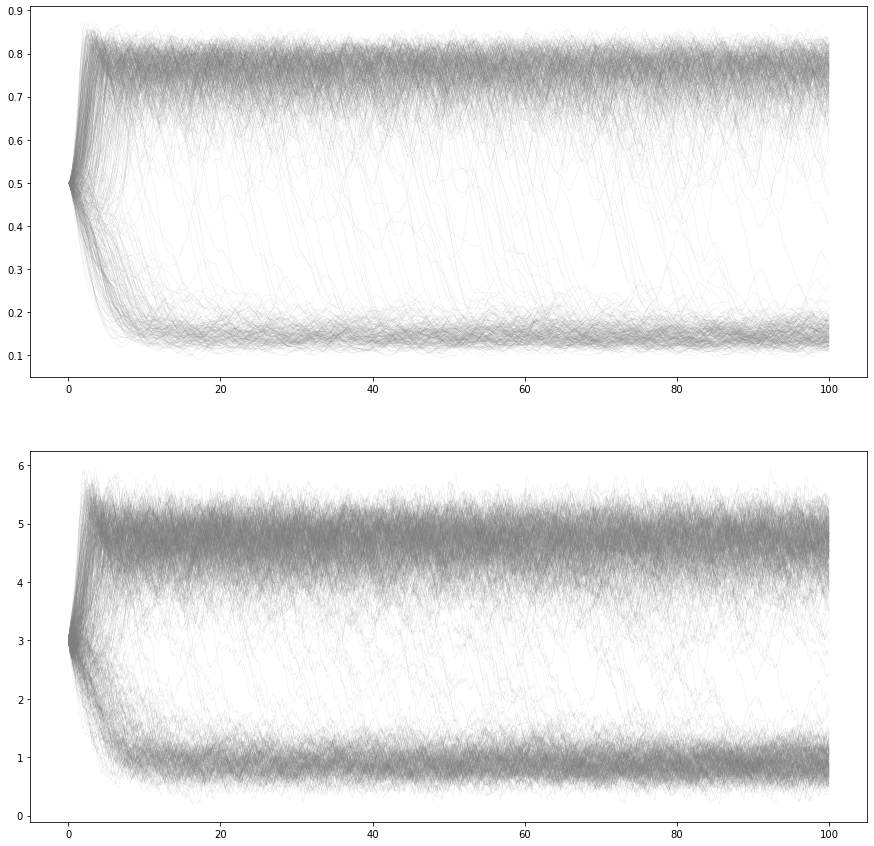

In [116]:
tgrid = [delta_t * k for k in range(N_sim + 1)]

# plt.figure(1, figsize=(10, 20))
# plt.clf()
f, [ax1,ax2] = plt.subplots(2,1,figsize=(15,15))



for i in range(len(traj_list)):
    x_trajectory_temp = traj_list[i]
    for j in range (Nx):
        x_opt = x_trajectory_temp[j::Nx]
        if j == 0:
            ax1.plot(tgrid, x_opt, 'grey',alpha=0.7,lw=0.1)
        else:
            ax2.plot(tgrid, x_opt, 'grey',alpha=0.7,lw=0.1)

# ax2.plot(tgrid, x2_mean, 'r', lw=3)
plt.show()

#### init = [0.7,5.]

In [117]:
N_sim = 1000
N_traj = 500
x_init = [0.7,5.]
theta_dist = 1
uk = 0

traj_list = []
for i in range(N_traj):
    xk = x_init
    traj_temp_list = []
    traj_temp_list += xk
    for j in range(N_sim):
        theta_k = np.random.uniform(-theta_dist,theta_dist,1)
        xk_p1 = ode_dis_func(xk,uk,theta_k)
        traj_temp_list += xk_p1.full().flatten().tolist()
        xk = xk_p1
    traj_list += [traj_temp_list]

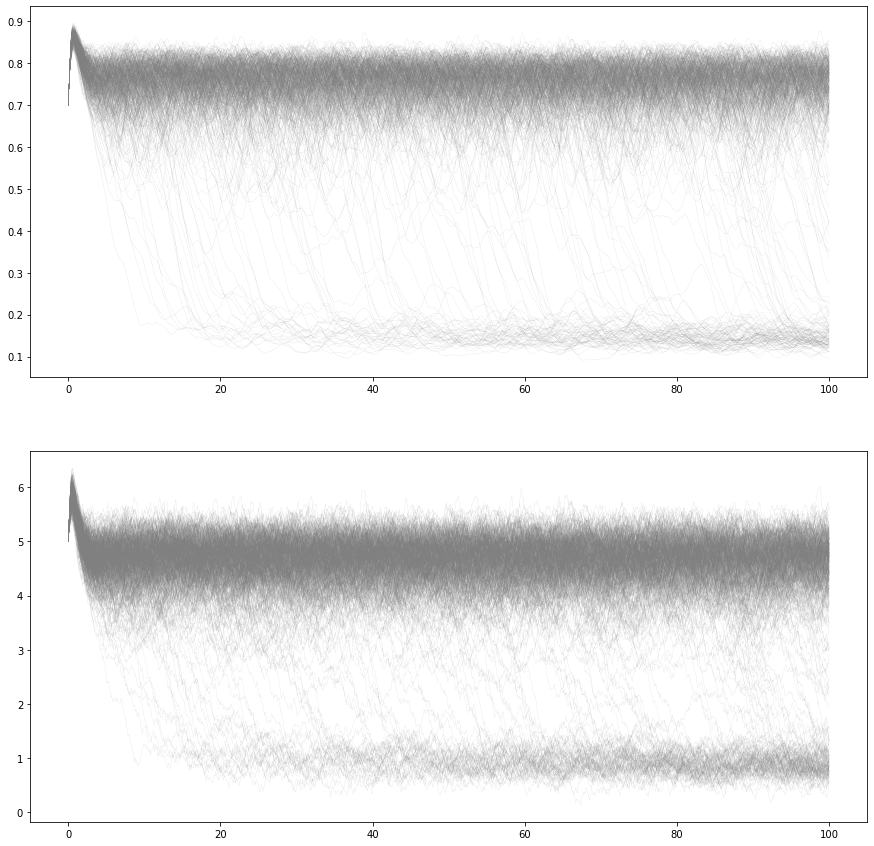

In [118]:
tgrid = [delta_t * k for k in range(N_sim + 1)]

# plt.figure(1, figsize=(10, 20))
# plt.clf()
f, [ax1,ax2] = plt.subplots(2,1,figsize=(15,15))



for i in range(len(traj_list)):
    x_trajectory_temp = traj_list[i]
    for j in range (Nx):
        x_opt = x_trajectory_temp[j::Nx]
        if j == 0:
            ax1.plot(tgrid, x_opt, 'grey',alpha=0.7,lw=0.1)
        else:
            ax2.plot(tgrid, x_opt, 'grey',alpha=0.7,lw=0.1)

# ax2.plot(tgrid, x2_mean, 'r', lw=3)
plt.show()